In [1]:
import numpy as np
from loading import *
#from functions import *
import netCDF4
import h5netcdf
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from datetime import datetime, timedelta

import holoviews as hv
import hvplot.pandas
import hvplot.xarray
hv.extension('bokeh')
from holoviews import opts
from holoviews.plotting.links import DataLink
from holoviews.element import tiles
import geoviews.tile_sources as gts
import panel as pn
import holoviews.operation.datashader as hd
import datashader as ds

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import Sampler
import math
from torch import optim

import torch.nn as nn
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

#Avoid warning
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")

from sklearn.metrics import mean_squared_error
all_MSE = {}

# README
- This part is only on Data analysis and Linear Regression
- There is a overleaf paper associated to this file, you can ask me if you want me to share it. I put the pdf of this paper in the folder as "mathias_paper.pdf". This file explain the project aswell.

# Preparing the data

In [2]:
radar_xarray = load_radar()

radar_xarray = radar_xarray.rename({"var0_1_201_surface":"radar"})
coords = load_coords()
rain = load_gauges_values()
rain = rain[rain.index.month < 4]

#shift hours
radar_xarray["time"] = radar_xarray["time"] + np.timedelta64(10,"h")
radar_xarray = radar_xarray.sel(time=slice( None, rain.index[-1]))

#Same timestamp for rain and radar
rain = rain[rain.index >= radar_xarray["time"][0].values]
rain = rain.resample("H").bfill()

rain.columns = pd.RangeIndex(start=0, stop=371, step=1, name='location')

#REMOVE NA and 0 values

# Keeping gauge with few NA values
rain = rain[rain.columns[(rain.isna().sum() < rain.shape[0]*0.1)]]

#Remove gauge with a unique value of 0.0 (removes 96 gauge!!!!!)
zero_index = []
for col in rain.columns:
    if (len(rain[col].unique()) <= 1):
        zero_index += [col]
rain = rain.drop(zero_index, axis=1)

# Filling NA
rain = rain.fillna(method="bfill")
rain = rain[:-1]

# Selection of coord colums
coords = coords.loc[rain.columns]

#Drop attribute of dataset
radar_xarray.lat.attrs.clear()
radar_xarray.lon.attrs.clear()

/tmp/ipykernel_6790/223170496.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rain = rain.fillna(method="bfill")


# Radar visualisation

## Plot on Japan
Type of map

- EsriTerrain : white map with topology (good for screenshots)
- OpenTopoMap : Show the topology really well, too much info on the map
- EsriWorldTopo : bit better than esiTerrain, bit slower, city name

Image alpe japonnaise
https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.snowmonkeyresorts.com%2Factivities%2Ftateyama-mountains-top-3-viewing-spots%2F&psig=AOvVaw2wglgMde15V38Ytsc5z4dV&ust=1710915689855000&source=images&cd=vfe&opi=89978449&ved=0CBMQjRxqFwoTCOjto-HX_4QDFQAAAAAdAAAAABAE

good rain time : 2010-01-02 19:00:00

In [3]:
plot_radar = radar_xarray.hvplot.image(x="lon", y="lat", c="radar", width=600, height=600,
                                       title="radar mesure", geo=True, tiles='EsriWorldTopo', alpha=0.5)
#plot_radar

In [4]:
#One image
#im1 = radar_xarray.sel(time="2010-01-02 19:00:00").hvplot.image(x="lon", y="lat", c="radar", width=600, height=600,
#                                       title="", geo=True, tiles='EsriWorldTopo', alpha=0.4, clabel="précipitations en mm")
#im1

In [5]:
#plot_gauge = gauge_xarray.sel(time="2010-01-02 19:00:00").hvplot.scatter(x="lat", y="lon", c="radar", width=600, height=600,
#                                        clabel="précipitations en mm", title="")
#plot_gauge * gts.EsriTerrain()

In [6]:
easting, northing = hv.util.transform.lon_lat_to_easting_northing(radar_xarray.lon, radar_xarray.lat)
rad_cpy = radar_xarray
rad_cpy = rad_cpy.assign_coords(lat=northing, lon=easting)
plot_radar = rad_cpy.hvplot.image(x="lon", y="lat", c="radar", width=600, height=600,
                                        alpha=0.5)

easting, northing = hv.util.transform.lon_lat_to_easting_northing(coords.lon, coords.lat)
gauge_xarray = xr.DataArray(data=rain.values,
                    coords={"lat" : ("coord", easting),
                     "lon" : ("coord", northing),
                     "time": rain.index.values},
                    dims=["time", "coord"],
                    name="radar"
                   )
plot_gauge = gauge_xarray.hvplot.scatter(x="lat", y="lon", c="radar", width=600, height=600)

#Plot
(plot_radar * plot_gauge * gts.EsriTerrain()).opts(hv.opts.Scatter(clim=(0,35)),
    hv.opts.Image(clim=(0,35)))

:DynamicMap   [time]
   :Overlay
      .Image.I   :Image   [lon,lat]   (radar)
      .Scatter.I :Scatter   [lat]   (lon,radar)
      .WMTS.I    :WMTS   [Longitude,Latitude]

## Data distribution

### Rainfall group by month
- Microclimat derriere les chaines de montagnes : matsumoto, takayamashi
- zone de radar non fonctionnel

In [7]:
radar_xarray.groupby("time.month").sum().hvplot.image(x="lon", y="lat", groupby="month",  c="radar", cnorm="log", width=600, height=600,
                                       title="radar mesure", geo=True, tiles='EsriWorldTopo', alpha=0.5)

:DynamicMap   [month]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [lon,lat]   (radar)

### Hist 
- Pas interssant, trop de valeur a 0
- Comment representer une telle distribution de donnee

In [8]:
radar_xarray.isel(lat=0, lon=0)["radar"].round().hvplot.hist()#.to_pandas().value_counts()
#PLOT LOG

:NdOverlay   [Element]
   :Histogram   [radar]   (radar_count)

## Outlier plot
- for each pixel, look at the min distance between the pixel and the 8 neighbors around

In [9]:
#conv = radar_xarray.rolling(lat=3, lon=3, center=True, min_periods=2).construct(window_dim={"lat": "lat2", "lon": "lon2"})
#mask1 = np.ones((3,3), dtype=bool)
#mask1[1,1]=False
#def diff_from_center(arr_2d, mask):
#    return np.nanmin(np.abs(arr_2d - arr_2d[1,1])[mask])
#    
##https://stackoverflow.com/questions/71413808/understanding-xarray-apply-ufunc    
#conv = xr.apply_ufunc(
#    diff_from_center,
#    conv.isel(lat=slice(None), lon=slice(None), time=slice(None)),
#    input_core_dims=[["lat2", "lon2"]],
#    #output_core_dims=[["lat"]],
#    exclude_dims=set(("lat2", "lon2")),
#    vectorize=True,
#    kwargs={"mask": mask1}
#)
#conv.to_netcdf("radar_diff.nc")

In [10]:
radar_diff = xr.open_dataset("dataset/radar_diff2.nc")
radar_diff = radar_diff.rename({"var0_1_201_surface": "radar"})
plot_radar_diff = radar_diff.hvplot.image(x="lon", y="lat", c="radar", width=600, height=600)

In [11]:
outlier_slicing = (radar_diff>20).sum(dim=["lat", "lon"]) > 0
mask = outlier_slicing["radar"].values
radar_diff.sel(time=mask).hvplot.image(x="lon", y="lat", c="radar", width=600, height=600)

:DynamicMap   [time]
   :Image   [lon,lat]   (radar)

In [12]:
#Reduce outliers values
radar_xarray = xr.where(radar_diff>20, radar_xarray - radar_diff, radar_xarray)

## Rain vs Gauge on location graph

In [13]:
radar_points = read_radar_from_coords(radar_xarray, coords)
radar = radar_points["radar"].to_pandas()
radar = radar[rain.columns]

In [14]:
radar_hour = radar.resample("H").mean()
radar_n = xr.DataArray(radar_hour.values, 
                  coords=[radar_hour.index, radar_hour.columns], 
                  dims=['time', 'location'],
                  name="rain")

gauge_n = xr.DataArray(rain.values, 
                  coords=[rain.index, rain.columns], 
                  dims=['time', 'location'],
                  name="rain")

precipitations = xr.Dataset({"gauge" : gauge_n, "radar": radar_n})

In [15]:
radar_n.hvplot(groupby=["location"], widget_location="top")

date_range_slider = pn.widgets.DatetimeRangeSlider(
    name='Date Range Slider',
    start=rain.index[0], end=rain.index[-1],
    step=1000*60*60
)

# Function to update the plot based on the selected gauge
def update_plot(x):
    p1 = precipitations.sel(time=slice(date_range_slider.value[0],date_range_slider.value[1])
                           ).hvplot(groupby=["location"], widget_location="top", ylabel="mm/10min")
    overlay_plot = p1
    return overlay_plot

pn.interact(update_plot, x=date_range_slider)

Column
    [0] Column
        [0] DatetimeRangeSlider(end=Timestamp('2010-03-31 2..., name='Date Range Slider', start=Timestamp('2010-01-01 1..., step=3600000, value=(Timestamp('2010-01-01 10:..., value_end=Timestamp('2010-03-31 2..., value_start=Timestamp('2010-01-01 1...)
    [1] Row
        [0] Column
            [0] WidgetBox(align=('center', 'start'))
                [0] DiscreteSlider(formatter='%d', margin=(20, 20, 20, 20), name='location', options=OrderedDict([('4', ...]), value=4, width=250)
            [1] HoloViews(DynamicMap, height=300, sizing_mode='fixed', widget_location='top', width=700)

# Pre processing
- Radar values are measured every 10 mins. Gauge values are measured every hours.
- Make an input X with with features beeing 10-20-30-40-50 mins, and y the gauge values

In [16]:
radar_point_grouped = radar_points.coarsen(time=6, boundary="trim").construct(time=("dim_h", "dim_m"))
radar_point_grouped.coords["hour"] = rain.index.values
radar_point_grouped.coords["min"] = [0,1,2,3,4,5]

radar_point_grouped["radar"] = radar_point_grouped["radar"].swap_dims(
    {"dim_h": "hour", "dim_m": "min"})
radar_point_grouped=radar_point_grouped.drop("time")
radar_point_grouped["radar"] = radar_point_grouped["radar"].transpose("location", "hour","min" )
radar_point_grouped = radar_point_grouped.assign(jauge=(("location", "hour"), rain.values.T))

#358
#171 -> south-east point
loc=358

#Input and output
y358 = rain[loc]
X358 = pd.DataFrame(radar_point_grouped.sel(location=loc)["radar"].values, 
                   index=rain.index)

#X358.index = y358.index
m_samples, n_features = X358.shape

#Normalisation
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X358[X358.columns] = scaler.fit_transform(X358[X358.columns])

#train data
X358_train = X358.iloc[ : int(m_samples * 0.8)]
y358_train = y358[ : int(m_samples * 0.8)]

#test data
X358_test = X358.iloc[int(m_samples * 0.8) : ]
y358_test = y358[int(m_samples * 0.8) : ]

# Regression Lineaire

## Mean

In [17]:
X358_result = pd.DataFrame(y358_test.values, index=X358_test.index, columns=["Mesure jauge"])
X358_result["0-Moyenne Radar"] = radar[loc].iloc[int(radar[loc].shape[0] * 0.8) : ].resample("1H").mean()
X358_result.hvplot.line(y=["0-Moyenne Radar", "Mesure jauge"], alpha=[0.9, 0.4], line_dash=["dotted", "solid", "dashed"],
                        ylabel="Precipitation en mm", xlabel="Date")

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

In [18]:
error = mean_squared_error(X358_result["0-Moyenne Radar"], X358_result["Mesure jauge"])
X358_sqrt_error = pd.Series(error, index=["0-Moyenne Radar"])

## Linear regression 1 data

### Train

In [19]:
def training_loop_t(model, loss_func, optimizer, X_train, y_train, X_test, y_test, epoch):  
    train_loss_evo = []
    test_loss_evo = []
    
    epoch_evo = pd.DataFrame()
    
    i=0

    for epoch in range(epoch):
        pred = model(X_train)
        loss = loss_func(pred, y_train)
        
        optimizer.zero_grad()
    
        loss.backward()
        
        optimizer.step()
    
        train_loss_evo.append(loss.detach().numpy())
        
        #TESTING
        model.eval()
        with torch.inference_mode(): 
            test_pred = model(X_test)
            test_loss = loss_func(test_pred, y_test)
            
            test_loss_evo.append(test_loss.detach().numpy())
            
            if (i % 10 == 0):
                epoch_evo[i] = pd.Series(test_pred.detach().numpy().flatten())
        i+=1
            
    return train_loss_evo, test_loss_evo, epoch_evo


In [20]:
#Data prep
X_train = torch.tensor(X358_train.values, dtype=torch.float)
y_train = torch.tensor(y358_train.values, dtype=torch.float)
X_test = torch.tensor(X358_test.values, dtype=torch.float)
y_test = torch.tensor(y358_test.values, dtype=torch.float)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

#Model prep
torch.manual_seed(42)

class linear_Regression(nn.Module):
    def __init__(self, n_features: int):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=n_features, out_features=1)
        
    def forward(self, xb: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(xb)
    
model358 = linear_Regression(X_train.shape[1])
loss_func358 = nn.MSELoss()
optimizer358 = optim.SGD(model358.parameters(), lr=0.01)

#PATH="./Paper_model/linear_jauge358"
#PATH="./Paper_model/linear_jauge171"
PATH="./Paper_model/linear_jauge358"
do_train=False
if do_train==True : 
    train_loss, test_loss, epoch_evo = training_loop_t(model358, loss_func358, optimizer358,
                                      X_train, y_train, X_test, y_test,
                                      100000)
    torch.save({"train_loss" : train_loss, 
                "valid_loss" : test_loss,
                "epoch_evo" : epoch_evo,
                "model" :  model358}, PATH)
    
else :    
    checkpoint = torch.load(PATH)
    train_loss = checkpoint['train_loss']
    test_loss = checkpoint['valid_loss']
    epoch_evo = checkpoint['epoch_evo']
    model358 = checkpoint['model']



### Evaluation

#### Cost
- evolution par epoque du modele
- test/train loss curve

In [21]:
moy_plot = X358_result.iloc[10:130].hvplot.line(y=["0-Moyenne Radar"], alpha=0.7,
                        line_dash=["dashed"], ylabel="Precipitation en mm", xlabel="Date", label="Mesure jauge",
                       width=800, height=400)

xr_epoch_evo = xr.DataArray(epoch_evo.values, 
                  coords=[y358_test.index, epoch_evo.columns], 
                  dims=['time', 'epoch'],
                  name="training evo")
(xr_epoch_evo.isel(time=slice(10,130)).hvplot.line(x="time", y="training evo", label="Regression lineaire") * moy_plot)

:DynamicMap   [epoch]
   :Overlay
      .Curve.Regression_lineaire :Curve   [time]   (training evo)
      .Curve.Mesure_jauge        :Curve   [timestamp]   (0-Moyenne Radar)

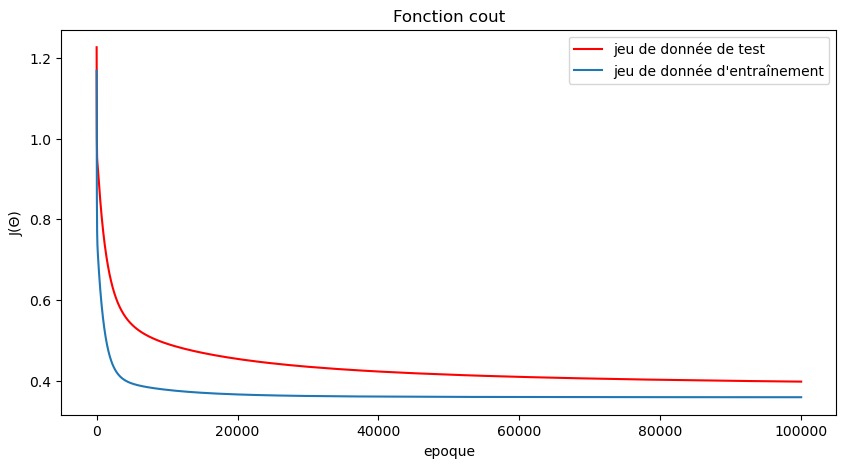

In [22]:
#Evolution de la fonction cout
plt.figure(figsize=(10,5))
plt.title("Fonction cout")
plt.plot(test_loss, c="r", label="jeu de donnée de test")
plt.plot(train_loss, label="jeu de donnée d'entraînement")
plt.xlabel("epoque")
plt.ylabel('J(Θ)')
plt.legend()
plt.show()

#### Comparaison
- Pareil que mean

In [23]:
X358_result["1-Regression lineaire"] = pd.Series(model358(X_test).detach().numpy().flatten(), index=y358_test.index)
X358_sqrt_error["1-Regression lineaire"] = mean_squared_error(X358_result["1-Regression lineaire"], X358_result["Mesure jauge"])

print(X358_sqrt_error)

X358_result.hvplot.line(y=["1-Regression lineaire", "Mesure jauge", "0-Moyenne Radar"], alpha=0.7,
                        line_dash=["solid", "dotted", "dashed"], ylabel="Precipitation en mm", xlabel="Date",
                       width=800, height=400)

0-Moyenne Radar          0.367271
1-Regression lineaire    0.398358
dtype: float64


:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

#### Eval on other gauge
- Lorsque l'on evalue sur tout les modeles, la moyenne a un meilleur score
- Sur la jauge 171 : il y a un enorme pic de pluie, le modele ne suit pas
- Sur la jauge 287 : le radar fait des erreurs de mesures
- MSE 0.64 > Moyenne MSE 0.43

In [24]:
sqrds = pd.DataFrame()

for loc in radar.columns.values:
    
    y = rain[loc]
    X = pd.DataFrame(radar_point_grouped.sel(location=loc)["radar"].values, 
                       index=rain.index)
    
    #X358.index = y358.index
    m_samples, n_features = X.shape
    
    #Normalisation
    
    scaler = preprocessing.MinMaxScaler()
    X[X.columns] = scaler.fit_transform(X[X.columns])
    
    #train data
    X_train = X.iloc[ : int(m_samples * 0.8)]
    y_train = y[ : int(m_samples * 0.8)]
    
    #test data
    X_test = X.iloc[int(m_samples * 0.8) : ]
    y_test = y[int(m_samples * 0.8) : ]
    
    X_train_t = torch.tensor(X_train.values, dtype=torch.float)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float)
    X_test_t = torch.tensor(X_test.values, dtype=torch.float)
    y_test_t = torch.tensor(y_test.values, dtype=torch.float)
    
    y_train_t = y_train_t.reshape(-1, 1)
    y_test_t = y_test_t.reshape(-1, 1)
    
    X_result = pd.DataFrame(y_test.values, index=X_test.index, columns=["Mesure jauge"])
    X_result["0-Moyenne Radar"] = radar[loc].iloc[int(radar[loc].shape[0] * 0.8) : ].resample("1H").mean()
    
    error = mean_squared_error(X_result["0-Moyenne Radar"], X_result["Mesure jauge"])
    X_sqrt_error = pd.Series(error, index=["0-Moyenne Radar"])
    
    X_result["1-Regression lineaire"] = pd.Series(model358(X_test_t).detach().numpy().flatten(), index=y_test.index)
    X_sqrt_error["1-Regression lineaire"] = mean_squared_error(X_result["1-Regression lineaire"], X_result["Mesure jauge"])
    
    sqrds = pd.concat([sqrds, pd.DataFrame(X_sqrt_error, columns=[str(loc)])], axis=1)
    

In [25]:
print(sqrds.mean(axis=1))
all_MSE["Moyenne Radar"] = sqrds.mean(axis=1)["0-Moyenne Radar"]
all_MSE["Regression lineaire"] = sqrds.mean(axis=1)["1-Regression lineaire"]

0-Moyenne Radar          0.437756
1-Regression lineaire    0.646704
dtype: float64


In [26]:
sqrds.T.hvplot.bar()

:Bars   [index,Variable]   (value)

In [27]:
#loc=171 --> enorme pic de pluie mesuree par la jauge
#loc=287 --> Le radar semble avoir un pic anormal de pluie
#loc=279 --> Le radar semble avoir un pic anormal de pluie
#loc=352 --> La prediction est tres bonne

temp_loc=370
y = rain[temp_loc]
X = pd.DataFrame(radar_point_grouped.sel(location=temp_loc)["radar"].values, 
                   index=rain.index)

#X358.index = y358.index
m_samples, n_features = X.shape

#Normalisation

scaler = preprocessing.MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

#train data
X_train = X.iloc[ : int(m_samples * 0.8)]
y_train = y[ : int(m_samples * 0.8)]

#test data
X_test = X.iloc[int(m_samples * 0.8) : ]
y_test = y[int(m_samples * 0.8) : ]

X_train_t = torch.tensor(X_train.values, dtype=torch.float)
y_train_t = torch.tensor(y_train.values, dtype=torch.float)
X_test_t = torch.tensor(X_test.values, dtype=torch.float)
y_test_t = torch.tensor(y_test.values, dtype=torch.float)

y_train_t = y_train_t.reshape(-1, 1)
y_test_t = y_test_t.reshape(-1, 1)

X_result = pd.DataFrame(y_test.values, index=X_test.index, columns=["Mesure jauge"])
X_result["0-Moyenne Radar"] = radar[temp_loc].iloc[int(radar[temp_loc].shape[0] * 0.8) : ].resample("1H").mean()

error = mean_squared_error(X_result["0-Moyenne Radar"], X_result["Mesure jauge"])
X_sqrt_error = pd.Series(error, index=["0-Moyenne Radar"])

X_result["1-Regression lineaire"] = pd.Series(model358(X_test_t).detach().numpy().flatten(), index=y_test.index)
X_sqrt_error["1-Regression lineaire"] = mean_squared_error(X_result["1-Regression lineaire"], X_result["Mesure jauge"])

X_result.hvplot.line(y=["1-Regression lineaire", "Mesure jauge", "0-Moyenne Radar"], alpha=0.7,
                        line_dash=["solid", "dotted", "dashed"], ylabel="Precipitation en mm", xlabel="Date",
                       width=800, height=400)

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

In [28]:
diff_serie = sqrds.loc["1-Regression lineaire"]/sqrds.loc["0-Moyenne Radar"]
diff_serie[diff_serie.loc[:] > 1.5] = 2
diff_serie[(diff_serie.loc[:] <= 1.5) & (diff_serie.loc[:] > 0.8)] = 1
diff_serie[diff_serie.loc[:] <= 0.8] = 0
#diff_serie = diff_serie.replace({2: "moyenne performe", 1:"even", 0:"modele perform"})
diff_serie = diff_serie.replace({2: "red", 1:"blue", 0:"green"})

In [29]:
easting, northing = hv.util.transform.lon_lat_to_easting_northing(coords.lon, coords.lat)
pair_point = pd.concat([easting, northing],axis=1)
pair_point["labels"] = diff_serie.values
pair_point.hvplot.points("lon","lat", color="labels", width=700, height=600) * gts.EsriWorldTopo()

:Overlay
   .Points.I :Points   [lon,lat]   (labels)
   .WMTS.I   :WMTS   [Longitude,Latitude]

In [30]:
#easting, northing = hv.util.transform.lon_lat_to_easting_northing(coords.lon[[loc,171, 279, 352, 170]], coords.lat[[loc,171, 279, 352, 170]])
#pair_point = pd.concat([easting, northing],axis=1)
#pair_point["labels"] = ["training", "Pic de pluie1", "Erreure mesure du radar", "Prediction correcte", "170"]
#pair_point.hvplot.points("lon","lat", color="labels", width=800, height=600) * gts.EsriWorldTopo()

## Linear regression all data

### Train

In [31]:
def training_loop_t2(model, loss_func, optimizer, train_dataloader, test_dataloader, epoch):  
    train_loss_evo = []
    test_loss_evo = []
    
    epoch_evo = pd.DataFrame()
    coef_evo = pd.DataFrame()
    
    abs_step=0

    for epoch in range(epoch):
        t_l=0
        model.train()
        for X, y in train_dataloader:
            pred = model(X)
            loss = loss_func(pred, y)
            t_l += loss.detach().numpy()
            
            optimizer.zero_grad()
        
            loss.backward()
            
            optimizer.step()
            #print(loss.detach())
        
            if (abs_step % 20 == 0):
                coef_evo[abs_step] = pd.Series(model.state_dict()["linear_layer.weight"].detach().numpy().flatten())
            abs_step+=1
        print("loss : ", t_l / len(train_dataloader))
        train_loss_evo.append(t_l / len(train_dataloader))
        
        #TESTING
        model.eval()
        with torch.inference_mode(): 
            t_l=0
            for X, y in test_dataloader:
                test_pred = model(X)
                test_loss = loss_func(test_pred, y)
                t_l += test_loss.detach().numpy()
                
            test_loss_evo.append(t_l / len(test_dataloader))
                    
    return train_loss_evo, test_loss_evo, coef_evo


In [32]:
#Data prep
#Shuffle date and loc
torch.manual_seed(2)
all_date = rain.index.values
t_train = all_date[: int(0.8 * len(all_date))]
t_test = all_date[int(0.8 * len(all_date)):]
X_train = torch.tensor(radar_point_grouped["radar"].sel(hour=t_train).values, dtype=torch.float)
X_train = X_train.flatten(0,1)
y_train = torch.tensor(rain.T[t_train].values, dtype=torch.float)
y_train = y_train.flatten(0,1)

X_test = torch.tensor(radar_point_grouped["radar"].sel(hour=t_test).values, dtype=torch.float)
X_test = X_test.flatten(0,1)
y_test = torch.tensor(rain.T[t_test].values, dtype=torch.float)
y_test = y_test.flatten(0,1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Setup the batch size hyperparameter
BATCH_SIZE = 64 

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(TensorDataset(X_train, y_train), 
    batch_size=BATCH_SIZE, 
    shuffle=True 
)

valid_dataloader = DataLoader(TensorDataset(X_test, y_test),
    batch_size=BATCH_SIZE,
    shuffle=False 
)
  
model = linear_Regression(X_train.shape[1])
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

PATH="./Paper_model/linear_all"
do_train=False
if do_train==True : 
    train_loss, test_loss, coef_evo = training_loop_t2(model, loss_func, optimizer,
                                      train_dataloader, valid_dataloader,
                                      10)
    torch.save({"train_loss" : train_loss, 
                "valid_loss" : test_loss,
                "coef_evo" : coef_evo,
                "model" :  model}, PATH)
    
else :    
    checkpoint = torch.load(PATH)
    train_loss = checkpoint['train_loss']
    test_loss = checkpoint['valid_loss']
    model = checkpoint['model']
    coef_evo = checkpoint['coef_evo']

### Evaluation
- Les coefficients tendent vers 1/6, ce qui revient a faire la moyenne
- MSE 0.42, mieux que la moyenne de 0.44

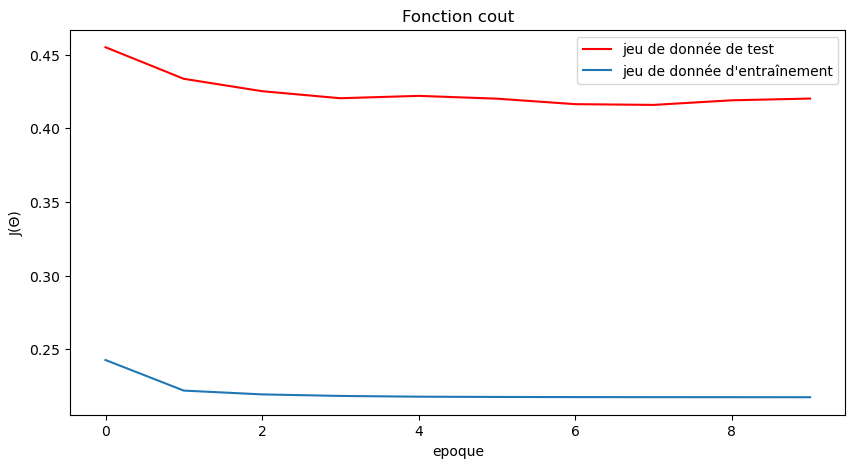

In [33]:
#Evolution de la fonction cout
plt.figure(figsize=(10,5))
plt.title("Fonction cout")
plt.plot(test_loss, c="r", label="jeu de donnée de test")
plt.plot(train_loss, label="jeu de donnée d'entraînement")
plt.xlabel("epoque")
plt.ylabel('J(Θ)')
plt.legend()
plt.show()

#### Comparaison avec la moyenne
- Suit la moyenne en donnant des valeurs un peu plus faibles.

In [34]:
index_loc=0
X_result=pd.DataFrame(index=t_test)

X_pred = radar_point_grouped["radar"].sel(hour=t_test).isel(location=index_loc)
X_result["Regression lineaire ALL"] = model(torch.tensor(X_pred.values, dtype=torch.float)).squeeze(1).detach().numpy()
X_result["Moyenne Radar"] = X_pred.mean(dim="min").values
X_result["Mesure jauge"] = rain.loc[t_test].iloc[:,index_loc].values

xr_coef_evo = xr.DataArray(coef_evo.values, 
                  coords=[coef_evo.index, coef_evo.columns], 
                  dims=['coef', 'epoch'],
                  name="training evo")

X_result.hvplot(y=["Regression lineaire ALL", "Moyenne Radar", "Mesure jauge"],
                alpha=[0.8, 0.6, 0.6], line_dash=["solid", "dashed", "dotted"],
                width=800, height=400)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

#### Evolution des coeff
- tendent tous vers la meme valeur
- tendent vers un peu moins que 1/6

In [35]:
xr_coef_evo.hvplot.bar(x="coef", y="training evo", ylim=(-0.5,1))

:DynamicMap   [epoch]
   :Bars   [coef]   (training evo)

#### MSE on each jauge
- Mauvaise prediction dans le sud-est : zone a forte pluie

In [36]:
sqrd_errors = pd.DataFrame()

for loc in range(rain.shape[1]):
    X_result=pd.DataFrame()
    
    X_pred = radar_point_grouped["radar"].sel(hour=t_test).isel(location=loc)
    X_result["Regression lineaire ALL"] = model(torch.tensor(X_pred.values, dtype=torch.float)).squeeze(1).detach().numpy()
    X_result["Moyenne Radar"] = X_pred.mean(dim="min").values
    X_result["Mesure jauge"] = rain.loc[t_test].iloc[:,loc].values
    
    #X_result["Regression lineaire ALL"] = pd.Series(model(X_test[loc]).detach().numpy().flatten())
    #X_result["Mesure jauge"] = y_test[:,loc]
    #X_result["Moyenne Radar"] = radar_point_grouped["radar"].sel(hour=t_test).isel(location=loc).mean(dim="min").values
    X_sqrt_error = pd.Series(mean_squared_error(X_result["Regression lineaire ALL"], X_result["Mesure jauge"]), index=["Regression Lineaire"])
    X_sqrt_error["Moyenne"] = mean_squared_error(X_result["Moyenne Radar"], X_result["Mesure jauge"])

    sqrd_errors = pd.concat([sqrd_errors, pd.DataFrame(X_sqrt_error, columns=[str(loc)])], axis=1)

print(sqrd_errors.mean(axis=1))
all_MSE["Regression Lineaire all gauge"] = sqrd_errors.mean(axis=1)["Regression Lineaire"]

Regression Lineaire    0.420365
Moyenne                0.437756
dtype: float64


In [37]:
sqrd_errors.T.hvplot.bar()

:Bars   [index,Variable]   (value)

In [38]:
diff_serie = sqrd_errors.loc["Regression Lineaire"]/sqrd_errors.loc["Moyenne"]
diff_serie[diff_serie.loc[:] > 1.5] = 2
diff_serie[(diff_serie.loc[:] <= 1.5) & (diff_serie.loc[:] > 0.8)] = 1
diff_serie[diff_serie.loc[:] <= 0.8] = 0
#diff_serie = diff_serie.replace({2: "moyenne performe", 1:"even", 0:"modele perform"})
diff_serie = diff_serie.replace({2: "red", 1:"blue", 0:"green"})

In [39]:
easting, northing = hv.util.transform.lon_lat_to_easting_northing(coords.lon, coords.lat)
pair_point = pd.concat([easting, northing],axis=1)
pair_point["labels"] = diff_serie.values
pair_point.hvplot.points("lon","lat", color="labels", width=700, height=600) * gts.EsriWorldTopo()

:Overlay
   .Points.I :Points   [lon,lat]   (labels)
   .WMTS.I   :WMTS   [Longitude,Latitude]

In [40]:
green_loc = pair_point[pair_point["labels"] == "green"].index
red_loc = pair_point[pair_point["labels"] == "red"].index
blue_loc = pair_point[pair_point["labels"] == "blue"].index

In [41]:
print("Moyenne pluie des mauvaises predictions :", radar_points.sel(location=red_loc)["radar"].mean().values)
print("Moyenne pluie des bonne predictions :",radar_points.sel(location=green_loc)["radar"].mean().values)
print("Moyenne pluie des even predictions :",radar_points.sel(location=blue_loc)["radar"].mean().values)

Moyenne pluie des mauvaises predictions : 0.31954286
Moyenne pluie des bonne predictions : 0.26299277
Moyenne pluie des even predictions : 0.26668718


In [44]:
0.263*100/0.3195

82.31611893583725

In [45]:
0.3195*100/0.2629

121.5290985165462

In [42]:
plt1 = radar_points.sel(location=red_loc).groupby("time.date").mean().mean(dim="location").hvplot(y="radar", label="red", color="red")
plt2 = radar_points.sel(location=green_loc).groupby("time.date").mean().mean(dim="location").hvplot(y="radar", label="green", color="green")
plt3 = radar_points.sel(location=blue_loc).groupby("time.date").mean().mean(dim="location").hvplot(y="radar", label="blue", color="blue")

plt1 * plt2 * plt3

:Overlay
   .Curve.Red   :Curve   [date]   (radar)
   .Curve.Green :Curve   [date]   (radar)
   .Curve.Blue  :Curve   [date]   (radar)

## Linear regression with TimeWindow

### Train

In [43]:
#best rolled = 3
rolled_value = 17
#Data prep
radar_rolled = radar_point_grouped.rolling(dim={"hour":rolled_value}, center=True).construct("rolled").fillna(0)

#Shuffle date and loc
torch.manual_seed(2)
all_date = rain.index.values
t_train = all_date[: int(0.8 * len(all_date))]
t_test = all_date[int(0.8 * len(all_date)):]
X_train = torch.tensor(radar_rolled["radar"].stack(variables=["rolled", "min"]
                                            ).sel(hour=t_train
                                            ).values.reshape(-1,rolled_value*6), 
                       dtype=torch.float)
y_train = torch.tensor(rain.loc[t_train].unstack(level=0).values, dtype=torch.float)

X_test = torch.tensor(radar_rolled["radar"].stack(variables=["rolled", "min"]
                                            ).sel(hour=t_test
                                            ).values.reshape(-1,rolled_value*6), 
                       dtype=torch.float)
y_test = torch.tensor(rain.loc[t_test].unstack(level=0).values, dtype=torch.float)


y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
  
model = linear_Regression(X_train.shape[1])
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

train_loss, test_loss, epoch_evo = training_loop_t(model, loss_func, optimizer,
                                      X_train, y_train, X_test, y_test,
                                      500)

KeyboardInterrupt: 

### Evaluation
- MSE 0.38 < MSE sans TimeWindow 0.42  < MSE Moyenne 0.44
- En fonction de la time window choisis (1,3,5,7...) la MSE change bcp, minimum pour une time window de 3h --> check PCA/ features correlation
- Coefficients lointains de l'heure predis sont attenue.

In [ ]:
inde = pd.timedelta_range(start=f'-{int(rolled_value/2)} hours', end=f'{int(rolled_value/2)} hours 50 minutes', freq='10T')
df = pd.DataFrame(model.state_dict()["linear_layer.weight"][0].numpy(), columns=["Coefficient value"])
df = df.set_index(inde)
df.hvplot.area(width=600, height=400)
#plt.bar(range(-3*rolled_value,3*rolled_value), model.state_dict()["linear_layer.weight"][0].numpy())
#plt.xlabel('Coefficient number')
#plt.ylabel('Coefficient value')
#
#plt.savefig('window_coef.png', dpi=300, bbox_inches='tight')

In [ ]:
#Evolution de la fonction cout
plt.figure(figsize=(10,5))
plt.title("Fonction cout")
plt.plot(test_loss, c="r", label="jeu de donnée de test")
plt.plot(train_loss, label="jeu de donnée d'entraînement")
plt.xlabel("epoque")
plt.ylabel('J(Θ)')
plt.legend()
plt.show()

In [ ]:
X_result=pd.DataFrame()
X_result["Regression lineaire Time Window"] = pd.Series(model(X_test).detach().numpy().flatten())
X_result["Mesure jauge"] = y_test
X_result["Moyenne Radar"] = radar_point_grouped["radar"].sel(hour=t_test).mean(dim="min").values.reshape(-1)
 
moy_plot = X_result.iloc[10:600].hvplot.line(y=["Mesure jauge", "Moyenne Radar"], alpha=0.7,
                        line_dash=["dashed", "dotted"], ylabel="Precipitation en mm", xlabel="Date", label="Mesure jauge",
                       width=800, height=400)

xr_epoch_evo = xr.DataArray(epoch_evo.values, 
                  coords=[epoch_evo.index, epoch_evo.columns], 
                  dims=['time', 'epoch'],
                  name="training evo")
(xr_epoch_evo.isel(time=slice(10,600)).hvplot.line(x="time", y="training evo", label="Regression lineaire") * moy_plot) 


In [ ]:
print("Erreur regression lineaire : ", 
      mean_squared_error(X_result["Regression lineaire Time Window"], X_result["Mesure jauge"]))
print("Erreur moyenne : ", 
      mean_squared_error(X_result["Moyenne Radar"], X_result["Mesure jauge"]))

all_MSE["Regression lineaire Time Window"] = mean_squared_error(X_result["Regression lineaire Time Window"], X_result["Mesure jauge"])

In [ ]:
# Evolution of MSE when increasing the time window
time_win = [1,2,3,4,5,7,9,11,13,18]
msr = [0.41643557,
       0.4158692,
 0.38408822,
 0.38669142,
 0.39108336,
 0.3931996,
 0.39398363,
 0.39428228,
 0.39454624,
 0.3951082]

plt.plot(time_win, msr)
plt.xlabel('Fenetre temporelle')
plt.ylabel('Erreur quadratique moyenne J')
plt.xticks(time_win)
plt.show()

#plt.savefig('MSE_window.png', dpi=300, bbox_inches='tight')

### Features correlation

- Correlation of coefficients with the target

In [ ]:
a = torch.cat((X_train, y_train), dim=1)
corr = torch.corrcoef(a.T)[:-1,-1]

plt.bar(range(-3*rolled_value, 3*rolled_value), corr.numpy())
plt.xlabel("Coefficients")
plt.ylabel("Correlation %")

### PCA (Principal Component Analysis)
- Performance en dessous de la moyenne pour une PCA de 10
- Permet de voir les variables representant le mieux le modele.

In [ ]:
#pca_reduction
def pca_reduction(X, n_component, plot=True): #n_component<1 --> percentage pca   
    pca = PCA(n_components=n_component)
    principalComponents = pca.fit_transform(X)
    n=len(pca.explained_variance_ratio_)
    
    #explained variance
    cum_sum = np.cumsum(pca.explained_variance_ratio_)
    if plot==True:
        plt.figure(figsize=(n, 5))
        plt.bar(x=np.arange(1,n+1), height=pca.explained_variance_ratio_)
        plt.step(x=np.arange(1,n+1), y=cum_sum)
        plt.title(f"Cumulative explained variance \nTotal = {cum_sum[-1]}")
        plt.xlabel("component")
        plt.ylabel("explain variance %")
        plt.show()
    
    #Components
    pca_comp = pd.DataFrame(data=pca.components_, columns=X.columns)
    pca_comp = pca_comp.multiply(pca.explained_variance_ratio_, axis=0)

    indices_of_highest_values = pca_comp.sum().nlargest(10).index
    pca_comp = pca_comp[indices_of_highest_values]
    if plot==True:
        plt.figure(figsize=(n, 5))
        pca_comp.plot.bar(stacked=True)
        plt.title("Component composition from dataset most important features")
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.xlabel("component")
        plt.ylabel("composition")
        plt.show()

    return pd.DataFrame(data = principalComponents, index=X.index), pca

In [ ]:
col_names = [str(i)+ "0 minutes from t0" for i in list(range(-3*rolled_value, 3*rolled_value))]
X_train_red, pca = pca_reduction(pd.DataFrame(X_train.numpy(), columns=col_names), 5)

X_test_red = pca.transform(X_test.numpy())
X_test_red = torch.tensor(X_test_red, dtype=torch.float)
X_train_red = torch.tensor(X_train_red.values, dtype=torch.float)

model = linear_Regression(X_train_red.shape[1])
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

train_loss, test_loss, epoch_evo = training_loop_t(model, loss_func, optimizer,
                                      X_train_red, y_train, X_test_red, y_test,
                                      400)

In [ ]:
#Evolution de la fonction cout
plt.figure(figsize=(10,5))
plt.title("Fonction cout")
plt.plot(test_loss, c="r", label="jeu de donnée de test")
plt.plot(train_loss, label="jeu de donnée d'entraînement")
plt.xlabel("epoque")
plt.ylabel('J(Θ)')
plt.legend()
plt.show()

In [ ]:
X_result=pd.DataFrame()
X_result["Regression lineaire Time Window PCA"] = pd.Series(model(X_test_red).detach().numpy().flatten())
X_result["Mesure jauge"] = y_test
X_result["Moyenne Radar"] = radar_point_grouped["radar"].sel(hour=t_test).mean(dim="min").values.reshape(-1)
 
moy_plot = X_result.iloc[10:600].hvplot.line(y=["Mesure jauge", "Moyenne Radar"], alpha=0.7,
                        line_dash=["dashed", "dotted"], ylabel="Precipitation en mm", xlabel="Date", label="Mesure jauge",
                       width=800, height=400)

xr_epoch_evo = xr.DataArray(epoch_evo.values, 
                  coords=[epoch_evo.index, epoch_evo.columns], 
                  dims=['time', 'epoch'],
                  name="training evo")
(xr_epoch_evo.isel(time=slice(10,600)).hvplot.line(x="time", y="training evo", label="Regression lineaire") * moy_plot) 


In [ ]:
print("Erreur regression lineaire : ", 
      mean_squared_error(X_result["Regression lineaire Time Window PCA"], X_result["Mesure jauge"]))
print("Erreur moyenne : ", 
      mean_squared_error(X_result["Moyenne Radar"], X_result["Mesure jauge"]))

In [ ]:
X_result.iloc[10:600].hvplot.line(y=["NN Time Window", "Mesure jauge", "Moyenne Radar"], alpha=0.7,
                        line_dash=["solid", "dotted", "dashed"], ylabel="Precipitation en mm", xlabel="Date", label="Mesure jauge",
                       width=800, height=400)

In [ ]:
all_MSE["NN Time Window"] = mean_squared_error(X_result["NN Time Window"], X_result["Mesure jauge"])
all_MSE

# Ref
- forecast basics : https://neptune.ai/blog/time-series-prediction-vs-machine-learning
- forecast book : https://otexts.com/fpp2/
- forecast kagle : https://www.kaggle.com/learn/time-series
- machine learnia git : https://github.com/MachineLearnia
- machine learnia youtubr : https://www.youtube.com/@MachineLearnia
- nn.Tensor explained : https://pytorch.org/tutorials/beginner/nn_tutorial.html
- Pytorch 24H git : https://github.com/mrdbourke/pytorch-deep-learning/tree/main
- Pytorch 24H yt : https://www.youtube.com/watch?v=V_xro1bcAuA
- Intro deep learning handwritten digit : http://neuralnetworksanddeeplearning.com/chap1.html
- Combining Radar and Rain Gauge Rainfall Estimates for Flood Forecasting: A Case Study in The Jinzu River Basin, Japan : https://www.jstage.jst.go.jp/article/jscejer/73/5/73_I_251/_pdf
- Flood estimation using radar and raingauge data : https://www.sciencedirect.com/science/article/pii/S0022169400003504
- Kriging math : https://www.youtube.com/watch?v=J-IB4_QL7Oc
- Kringing python : https://www.youtube.com/watch?v=dcDQCarn6qg
- CNN online : https://poloclub.github.io/cnn-explainer/
- How to do better plot : https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.html
- Graph intro : https://distill.pub/2021/gnn-intro/
- CNN Mit video : https://www.youtube.com/watch?v=NmLK_WQBxB4&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=3
- CNN circuits : https://distill.pub/2020/circuits/
- Why we use batch : https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu
- Deep Learning book : https://www.deeplearningbook.org/
- batch normalization : https://arxiv.org/pdf/1502.03167
- Animated CNN : https://www.youtube.com/@animatedai/videos
- 3Blue1Brown : https://www.youtube.com/@3blue1brown
- batch norm video : https://www.youtube.com/watch?v=2xChdY2qkmc
- Unet pyttorch : https://www.youtube.com/watch?v=IHq1t7NxS8k&t=987s
- TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE : https://www.youtube.com/watch?v=TrdevFK_am4
- Vision transformer for 3D input: https://openaccess.thecvf.com/content/CVPR2023/html/Tarasiou_ViTs_for_SITS_Vision_Transformers_for_Satellite_Image_Time_Series_CVPR_2023_paper.html
- link to vision trasfo paper : https://scholar.google.com/scholar?cites=11707840604445812565&as_sdt=2005&sciodt=0,5&hl=en
- Attention 3Blue vid : https://www.youtube.com/watch?v=eMlx5fFNoYc

# blog
- Open AI research article : https://openai.com/research?page=9
- google blog : https://research.google/blog/
- google deepmind AI publication : https://deepmind.google/research/publications/

# Tristan recomandation
- Theory of deep learning (chapt 8) : https://pages.cs.wisc.edu/~yliang/cs839_spring22/material/DLbook.pdf
- Distill newspaper : https://distill.pub/2017/momentum/
- Offconvex articles : http://www.offconvex.org/
- Simon institute videos : https://www.youtube.com/@SimonsInstituteTOC
- graphCast weather prediction : https://deepmind.google/discover/blog/graphcast-ai-model-for-faster-and-more-accurate-global-weather-forecasting/ , https://sites.research.google/weatherbench/
- batch norm explain : https://colab.research.google.com/github/davidcpage/cifar10-fast/blob/master/batch_norm_post.ipynb#scrollTo=8tYJ_pwnvnM9

# Doc
- Sklearn : https://scikit-learn.org/

# Cheat sheet 
- pytorch : https://pytorch.org/tutorials/beginner/ptcheat.html
- numpy : https://images.datacamp.com/image/upload/v1676302459/Marketing/Blog/Numpy_Cheat_Sheet.pdf
- pandas : https://images.datacamp.com/image/upload/v1676302204/Marketing/Blog/Pandas_Cheat_Sheet.pdf
- data sciences : https://images.datacamp.com/image/upload/v1676302827/Marketing/Blog/Data_Wrangling_Cheat_Sheet.pdf
- see more datascience : https://towardsdatascience.com/collecting-data-science-cheat-sheets-d2cdff092855

# Open Data
weather data hourly, 0.1 degree resolution :  https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form


# Ideas
- Add the duration of rainfall?
- Seasonality 
- kriging of the gauge data (or radar?) in order to get rain values arround the gauges. But the radar are already giving a grid of the rain fall. So should i make a krigieing grid with more details?
- Conditionnal merging : https://www.j-kosham.or.kr/journal/view.php?doi=10.9798/KOSHAM.2019.19.6.41, 
file:///home/mathias/Downloads/Combining_radar_and_rain_gauge_rainfall_estimates_.pdf (https://www.researchgate.net/publication/229728321_Combining_radar_and_rain_gauge_rainfall_estimates_using_conditional_merging), 
https://www.iws.uni-stuttgart.de/publikationen/hydrologie/121_Ehret_Uwe.pdf
- Trouver un feature servant de declencheur de pluie (peut etre la temperature atmospherique)

- radar default : obstacles (birds, dust), distance

- Try to measure how impactfull are some feature (ex : is should my time window be 5hours, 6, 7?? How many neighbor should i take)

# Questions
- Comment trouver les meilleurs hyperparametres adam